# Text to SQL Similarity

The purpose of this task is to asses your independent work and familiarity with data analysis, Machine Learning and Natural Language Processing techniques. Feel free to use any libraries you want, any models necessary and to define any additional functions you might need. 

You are given a dataset with questions and their corresponding SQL queries.

Tasks:
1. Define 2 different similarity metrics between a question and a SQL query (your choice - be creative). The metrics should use different techniques and be based on different models.
2. Analyze the similarity metrics you defined above.
    
    * Define plots to visualize the performance of the similarity metrics (your choice - be creative)
    * Define a threshold (and how to choose it) for the similarity metrics to determine if a question is similar to a SQL query.
    * Calculate the precision, recall, and F1 score per similarity metric (for the threshold you defined) or other metrics of your choice that will help you compare between the metrics.
3. Summarize your findings and conclusions.




In [37]:
import pandas as pd
import numpy as np
import os
import openai


from tabulate import tabulate
from dotenv import load_dotenv
from datasets import Dataset
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, SemanticSimilarity
from ragas import evaluate
from openai import OpenAI

load_dotenv()
openai.api_key =  os.getenv("OPENAI_API_KEY")

df = pd.read_csv('data.csv')
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else ("" if pd.isnull(x) else x))
df= df.iloc[:50]
 

C:\Users\MSI KATANA\AppData\Local\Temp\ipykernel_30772\1843056841.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else ("" if pd.isnull(x) else x))


RAGAS :  Metric 1

In [38]:
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

df["retrieved_contexts"] = df["sql"].apply(lambda x: [x])  
df["reference"] = df["question"]
df["response"] = " "
 
dataset = Dataset.from_pandas(df)

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4-turbo"))
evaluator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())
 
metrics = [
    LLMContextRecall(llm=evaluator_llm),
    FactualCorrectness(llm=evaluator_llm),
    Faithfulness(llm=evaluator_llm),
    SemanticSimilarity(embeddings=evaluator_embeddings),
    context_precision ,
    answer_relevancy,
    context_recall  
]


results = evaluate(dataset=dataset, metrics=metrics)
df_eval = results.to_pandas()
required_df = df_eval[["user_input", "retrieved_contexts", "semantic_similarity"]]
required_df = required_df.rename(columns={
    'user_input': 'question', 
    'retrieved_contexts': 'SQL'
})
print(tabulate(required_df, headers='keys', tablefmt='pretty', showindex=False))



Evaluating:  13%|█▎        | 45/350 [00:18<01:49,  2.78it/s]Exception raised in Job[22]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
Exception raised in Job[29]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
Evaluating:  16%|█▋        | 57/350 [00:25<05:57,  1.22s/it]No statements were generated from the answer.
Exception raised in Job[43]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
Evaluating:  20%|██        | 70/350 [00:32<03:17,  1.42it/s]No statements were generated from the answer.
Exception raised in Job[57]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supp

+----------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

openai :  Metric 2

In [39]:
client = OpenAI()
 

# Function to predict the question based on SQL query
def get_predicted_question(sql_query):
    completion = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a helpful assistant who is really good at generating questions for SQL queries."},
            {"role": "user", "content": f"Generate the question that the following SQL query is answering:\n\n{sql_query}"}
        ]
    )
    return completion.choices[0].message.content

def get_similarity_score(original_question, predicted_question):
    completion = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a helpful assistant who is really good at sentence similarity matching.And you give the output always as a float number only. you never provide a String value or the descrition about your response"},
            {"role": "user", "content": f"Rate the similarity between these two questions on a scale from 0 to 1 (1 being identical). Make sure your only allowed response is only a float value with maximum 2 demial points. finla response only need to be that:\n\n1. {original_question}\n2. {predicted_question}"}
        ]
    )
    return  completion.choices[0].message.content.strip()


def get_direct_query_match_score(original_question, sql_query):
    completion = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a helpful assistant who is really good at   matching the relavancy of the sql query and the it's original question . you always give response as a interger only.every time your answer is a number . there is no explnation   "},
            {"role": "user", "content": f"Rate the realavancy between these   questions  and the sql statement  on a scale from 0 to 1 (1 being identical). Make sure your only allowed response is only a float value with maximum 2 demial points. finla response only need to be that:\n\n1. {original_question}\n2. {predicted_question}"}
        ]
    )
    return  completion.choices[0].message.content.strip()

predicted_questions = []
similarity_scores = []
sql_matching_scores = []

 
for index, row in required_df.iterrows():
    sql_query = row["SQL"]
    original_question = row["question"]
    
    # Get predicted question
    predicted_question = get_predicted_question(sql_query)
    predicted_questions.append(predicted_question)
    sql_matching_scores.append(get_direct_query_match_score(original_question ,original_question))
    
    # Calculate similarity score
    similarity_score = get_similarity_score(original_question, predicted_question)
    similarity_scores.append(similarity_score)

# Add results to DataFrame
required_df["predicted_question"] = predicted_questions
required_df["similarity_score"] = similarity_scores
required_df["sql_matching_scores"] = similarity_scores

# Print the updated DataFrame
print(tabulate(required_df, headers='keys', tablefmt='pretty', showindex=False))


+----------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Analyse

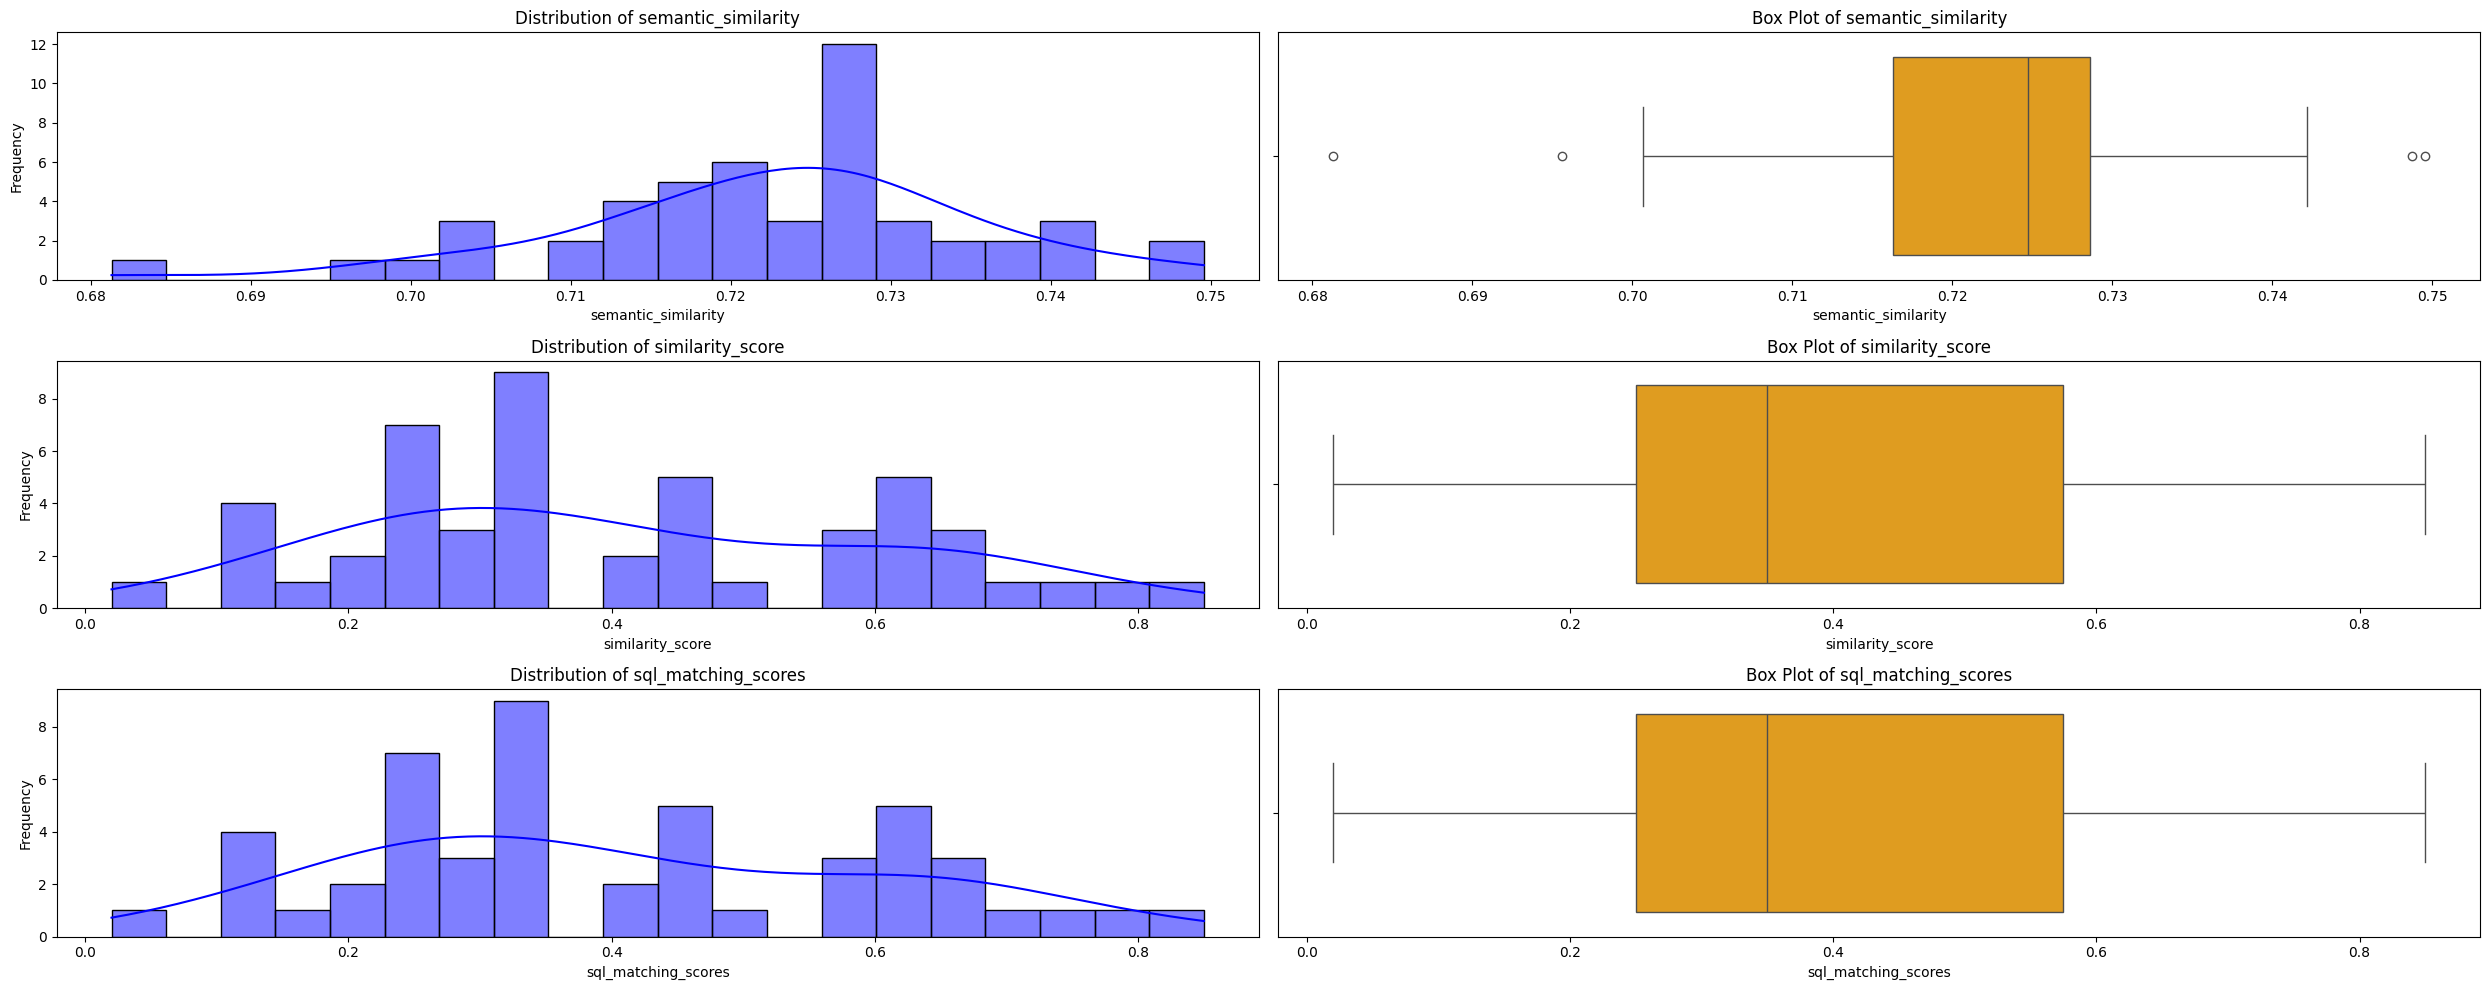

In [53]:

columns_to_analyze = ["semantic_similarity", "similarity_score", "sql_matching_scores"]
plt.figure(figsize=(25, 10))

for i, column in enumerate(columns_to_analyze, 1):
    plt.subplot(3, 2, i*2-1)   
    sns.histplot(required_df[column], bins=20, kde=True, color='blue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    plt.subplot(3, 2, i*2)  
    sns.boxplot(x=required_df[column], color='orange')
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()


In [44]:
for column in columns_to_analyze:
    required_df[column] = pd.to_numeric(required_df[column], errors="coerce")

Threshold Selection Metric 1 and Metric 2:


In [56]:
semantic_similarity_threshold = 0.725
similarity_score_threshold = 0.55
sql_matching_scores_threshold = 0.55


filtered_df = required_df[
    (required_df["semantic_similarity"] >= semantic_similarity_threshold) &
    (required_df["similarity_score"] >= similarity_score_threshold) &
    (required_df["sql_matching_scores"] >= sql_matching_scores_threshold)
]

column_to_move = "semantic_similarity"

columns = [col for col in filtered_df.columns if col != column_to_move]   
columns.append(column_to_move)   
filtered_df_final = filtered_df[columns]

 
print(tabulate(filtered_df_final, headers='keys', tablefmt='pretty', showindex=False))


+----------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Conclusion and Findings:

Based on the 3 matrics it's better to keep ovearll threshold around 0.65 to 0.7 for not to loose too much correct precditions.

For futher anlyase with mulitple model can be used the arize-phoenix ("llm_as_a_judge_eval")